In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split
from eigenface_project import eigenface_project
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from time import time, sleep

In [2]:
# Directory paths
train_dir = os.path.expanduser('../raw_data/fer2013/train')
test_dir = os.path.expanduser('../raw_data/fer2013/test')

# Define a function to load the balanced data
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(label)
    return images, labels

# Load training and testing images
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)


print(f"Loaded {len(train_images)} training images.")
print(f"Loaded {len(test_images)} testing images.")

Loaded 28709 training images.
Loaded 7178 testing images.


In [3]:
# Check the train and test data
print({x: train_labels.count(x) for x in set(train_labels)})
print(np.array(train_images).shape)

print({x: test_labels.count(x) for x in set(test_labels)})
print(np.array(test_images).shape)

{'happy': 7215, 'angry': 3995, 'disgust': 436, 'neutral': 4965, 'fear': 4097, 'surprise': 3171, 'sad': 4830}
(28709, 48, 48)
{'happy': 1774, 'angry': 958, 'disgust': 111, 'neutral': 1233, 'fear': 1024, 'surprise': 831, 'sad': 1247}
(7178, 48, 48)


In [4]:
# set up X, y of train and test
train_Class = np.array(train_labels)
train_images = np.array(train_images)

test_Class = np.array(test_labels)
test_images = np.array(test_images)

In [5]:
# project the image data on the eigen vectors
train_images_project, selected_eigenvectors=eigenface_project(train_images)

test_images_centered = test_images - np.mean(test_images, axis=0)
test_images_project = np.dot(test_images_centered.reshape(test_images.shape[0], -1), selected_eigenvectors)

In [6]:
# Assuming you have your data as X and y

def auto_xgboost(
    X,
    y,
    n_estimators=200,
    random_state=2024,
    cv=10
    ):
    # 1. Parameter grid
    param_grid = {
        'max_depth': [3, 5, 10, 20, 30],
        'learning_rate': [0.01, 0.05, 0.1],
        'colsample_bytree': [0.1, 0.2, 0.5]
        # 'min_child_weight': [1, 2, 5, 10, 20]
        # 'gamma': [0, 0.1],
        # 'subsample': [0.8, 1.0]
    }
    # 2. Create base model
    xgb_model = XGBClassifier(
        objective='multi:softmax',
        n_estimators= n_estimators,
        subsample = 0.5, # randomly sample 50% of the training data for each tree, avoid overfitting
        # use_label_encoder=False,
        eval_metric='merror',
        random_state=random_state
    )

    # 3. Setup StratifiedKFold
    skf = StratifiedKFold(
        n_splits=cv,
        shuffle=True,
        random_state=random_state
    )

    # 4. Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1, # use all the CPU cores
        verbose=2  # detailed output monitoring progress updates
    )

    # 5. Scale the features
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. Fit the model
    grid_search.fit(X_scaled, y_encoded)

    # 7. Best model
    best_model = grid_search.best_estimator_
    
    # 8. Best params
    best_par = grid_search.best_params_
    
    # 9. Best CV score
    best_score = grid_search.best_score_

    # 10. Feature importance
    feature_importance = pd.DataFrame({
        'feature': [f'feature_{i}' for i in range(X.shape[1])],
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # compile and return the results
    results = {
        'best_params': best_par,
        'best_score': best_score,
        'best_model': best_model,
        'feature_importance': feature_importance
    }

    return results, grid_search

In [7]:
start_time = time()

XGB_result, grid_search = auto_xgboost(X=train_images_project, y=train_Class)
  
end_time = time()
print(f"Runtime: {(end_time - start_time)/60} mins")

Fitting 10 folds for each of 45 candidates, totalling 450 fits


c:\Users\shiru\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\shiru\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\shiru\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\shiru\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\shiru\an

Runtime: 94.96682260036468 mins


In [8]:
# loop through and print the results
for key, value in XGB_result.items():
    print(f"{key}: \n {value}")

best_params: 
 {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 20}
best_score: 
 0.45187897234995633
best_model: 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)
feature_importance: 
          feature  importance
13    feature_13    0.014818
22    feature_22    0.014

In [15]:
# work on the test data set
# fit with the best model with 5000 trees
scaler = StandardScaler()
scaler.fit(train_images_project)
train_images_scaled = scaler.transform(train_images_project)
test_images_scaled = scaler.transform(test_images_project)

# encode the classes
label_encoder = LabelEncoder()
label_encoder.fit(train_Class)
train_Class_encoded = label_encoder.transform(train_Class)
test_Class_encoded = label_encoder.transform(test_Class)

X_ttrain, X_val, y_ttrain, y_val = train_test_split(train_images_scaled, train_Class_encoded, 
                                                  test_size=0.1, random_state=2024, stratify=train_Class_encoded)
    
    
xgb = XGBClassifier(max_depth=20, learning_rate=0.05,
                       random_state=2024, subsample = 0.5, n_estimators=5000, colsample_bytree=0.5,
                       objective='multi:softmax', eval_metric='merror', early_stopping_rounds=500)
xgb.fit(X_ttrain, y_ttrain, eval_set=[(X_val, y_val)])
# xgb.fit(train_images_scaled, train_Class_encoded)
train_Class_pred = xgb.predict(train_images_scaled)
test_Class_pred = xgb.predict(test_images_scaled)

[0]	validation_0-merror:0.75235
[1]	validation_0-merror:0.70568
[2]	validation_0-merror:0.69105
[3]	validation_0-merror:0.67816
[4]	validation_0-merror:0.67189
[5]	validation_0-merror:0.66040
[6]	validation_0-merror:0.66214
[7]	validation_0-merror:0.64995
[8]	validation_0-merror:0.63845
[9]	validation_0-merror:0.62905
[10]	validation_0-merror:0.62591
[11]	validation_0-merror:0.62104
[12]	validation_0-merror:0.61895
[13]	validation_0-merror:0.61198
[14]	validation_0-merror:0.61372
[15]	validation_0-merror:0.61686
[16]	validation_0-merror:0.60815
[17]	validation_0-merror:0.60397
[18]	validation_0-merror:0.60745
[19]	validation_0-merror:0.61094
[20]	validation_0-merror:0.60989
[21]	validation_0-merror:0.60711
[22]	validation_0-merror:0.60432
[23]	validation_0-merror:0.60084
[24]	validation_0-merror:0.59770
[25]	validation_0-merror:0.60014
[26]	validation_0-merror:0.60014
[27]	validation_0-merror:0.59317
[28]	validation_0-merror:0.59248
[29]	validation_0-merror:0.58934
[30]	validation_0-me

In [ ]:
# train accuracy
print(accuracy_score(train_Class_encoded, train_Class_pred))
        
# classification_report
print(classification_report(train_Class_encoded, train_Class_pred))

0.9457661360548957
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3995
           1       1.00      0.92      0.96       436
           2       0.96      0.92      0.94      4097
           3       0.92      0.98      0.95      7215
           4       0.95      0.94      0.94      4965
           5       0.93      0.94      0.94      4830
           6       0.97      0.96      0.96      3171

    accuracy                           0.95     28709
   macro avg       0.96      0.94      0.95     28709
weighted avg       0.95      0.95      0.95     28709



In [11]:
# train accuracy
print(accuracy_score(test_Class_encoded, test_Class_pred))
        
# classification_report
print(classification_report(test_Class_encoded, test_Class_pred))

0.47924212872666483
              precision    recall  f1-score   support

           0       0.44      0.25      0.32       958
           1       0.97      0.32      0.48       111
           2       0.48      0.29      0.37      1024
           3       0.48      0.77      0.59      1774
           4       0.43      0.43      0.43      1233
           5       0.39      0.37      0.38      1247
           6       0.69      0.60      0.64       831

    accuracy                           0.48      7178
   macro avg       0.56      0.43      0.46      7178
weighted avg       0.48      0.48      0.46      7178



In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [17]:
# comfusion matrix
test_Class_pred = label_encoder.inverse_transform(test_Class_pred) 
cm = confusion_matrix(test_Class, test_Class_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

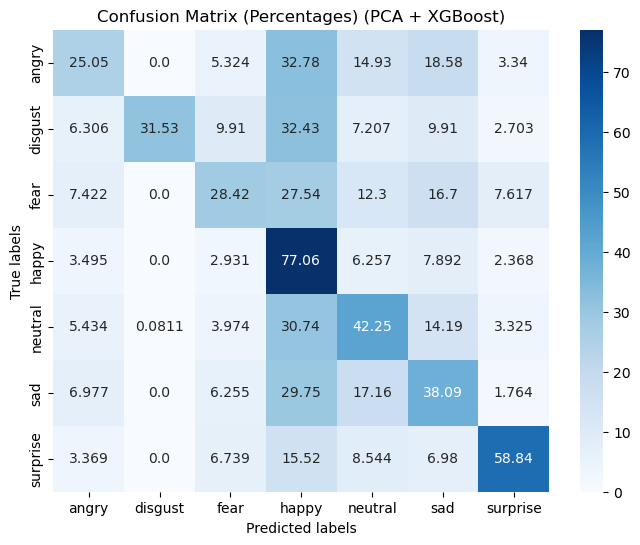

In [18]:
# Create the heatmap with annotations as percentages
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized*100, annot=True, fmt='.4', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)  # Format as percentages with 2 decimal places
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Percentages) (PCA + XGBoost)')
plt.show()